In [1]:
#DIR3122: Computational Fluid Dynamics - Bridget McGibbon
#Step 12: Finding a velocity and pressure field for pressure-driven channel flow, with periodic B.C.s

#Boundary Conditions:
#u,v,p are periodic on x=0,2 (i.e. u[0,:]=u[-1,:], etc.)
#u, v = 0 at y=0,2 (no-slip condition)
#dp/dy = 0 at y=0,2
#-dp/dx = F = 1 everywhere (a steady pressure gradient from left to right, driving the flow)

#note: total pressure P is the sum of the steady term F and unsteady term p

In [2]:
#same b function as step 11, but with periodic B.C.s
def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = rho * (1 / dt * ((u[2:,1:-1] - u[:-2,1:-1]) / 
                     (2 * dx) + (v[1:-1,2:] - v[1:-1,:-2]) / (2 * dy)) -
                    ((u[2:,1:-1] - u[:-2,1:-1]) / (2 * dx))**2 -
                      2 * ((u[1:-1,2:] - u[1:-1,:-2]) / (2 * dy) *
                           (v[2:,1:-1] - v[:-2,1:-1]) / (2 * dx))-
                          ((v[1:-1,2:] - v[1:-1,:-2]) / (2 * dy))**2)
    
    #periodic B.C. at x=2
    b[-1, 1:-1] = rho * (1 / dt * ((u[0,1:-1] - u[-2,1:-1]) / 
                     (2 * dx) + (v[-1,2:] - v[-1,:-2]) / (2 * dy)) -
                    ((u[0,1:-1] - u[-2,1:-1]) / (2 * dx))**2 -
                      2 * ((u[-1,2:] - u[-1,:-2]) / (2 * dy) *
                           (v[0,1:-1] - v[-2,1:-1]) / (2 * dx))-
                          ((v[-1,2:] - v[-1,:-2]) / (2 * dy))**2)
    #periodic B.C. at x=0
    b[0, 1:-1] = rho * (1 / dt * ((u[1,1:-1] - u[-1,1:-1]) / 
                     (2 * dx) + (v[0,2:] - v[0,:-2]) / (2 * dy)) -
                    ((u[1,1:-1] - u[-1,1:-1]) / (2 * dx))**2 -
                      2 * ((u[0,2:] - u[0,:-2]) / (2 * dy) *
                           (v[1,1:-1] - v[-1,1:-1]) / (2 * dx))-
                          ((v[0,2:] - v[0,:-2]) / (2 * dy))**2)
    

    return b

In [3]:
#V here can be either u or v (depending on the function input), and is the value being calculated
def convection_term(V, u, v, dt, dx, dy):
    
    Vn = V.copy()
    un = u.copy()
    vn = v.copy()
    
    V[1:-1, 1:-1] = -un[1:-1,1:-1]*dt/dx*(Vn[1:-1,1:-1]-Vn[0:-2,1:-1]) - vn[1:-1,1:-1]*dt/dy*(Vn[1:-1,1:-1]-Vn[1:-1,:-2])
        
    return V

In [10]:
#runtime warning, not a problem
def pressure_poisson(p, dx, dy, b, normtarget):
    pn = np.empty_like(p)
    pn = p.copy()
    norm = 1
    
    while norm > normtarget:
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[2:,1:-1] + pn[:-2,1:-1]) * dy**2 + (pn[1:-1,2:] + pn[1:-1,:-2]) * dx**2) /
                          (2 * (dx**2 + dy**2)) - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1,1:-1])
        
        #Periodic B.C. at x=2
        p[1:-1, 1:-1] = (((pn[0,1:-1] + pn[-2,1:-1]) * dy**2 + (pn[-1,2:] + pn[-1,:-2]) * dx**2) /
                          (2 * (dx**2 + dy**2)) - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[-1,1:-1])
        p[1:-1, 1:-1] = (((pn[1,1:-1] + pn[-1,1:-1]) * dy**2 + (pn[0,2:] + pn[0,:-2]) * dx**2) /
                          (2 * (dx**2 + dy**2)) - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[0,1:-1])
        
        #Wall B.C.s at y=0,2
        p[:,0] = p[:,1]
        p[:,-1] = p[:,-2]
        
        norm = np.sum(np.abs(p[:,:]) - np.abs(pn[:,:])) / np.sum(np.abs(pn[:,:]))
        
    return p

In [5]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [6]:
#define variables
nx = 41
ny = 41
nt = 10
normtarget = 1e-4
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
#X, Y = np.meshgrid(x, y)
Y, X = np.meshgrid(y, x) #weird stuff, working on it

rho = 1
nu = .1
dt = .001
F = 1


#I.C.: u=0, v=0, p=0 everywhere
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
p = np.zeros((nx, ny)) 
b = np.zeros((nx, ny))

In [7]:
def channelflow(u, v, p, b, normtarget):
    norm = 1
    while norm > normtarget:
        un = u.copy()
        vn = v.copy()
    
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, normtarget)

        u[1:-1, 1:-1] = un[1:-1, 1:-1] + convection_term(u, u, v, dt, dx, dy)[1:-1,1:-1] + nu*(dt/dx**2*(un[2:,1:-1] - 2*un[1:-1, 1:-1] + un[:-2,1:-1]) + dt/dy**2*(un[1:-1,2:] - 2*un[1:-1, 1:-1] + un[1:-1,0:-2])) - (dt/(2 * rho * dx)*(p[2:,1:-1]-p[:-2,1:-1])) + F*dt
        v[1:-1,1:-1] =  vn[1:-1, 1:-1] + convection_term(v, u, v, dt, dx, dy)[1:-1, 1:-1] + nu*(dt/dx**2*(vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[:-2,1:-1]) + dt/dy**2*(vn[1:-1,2:] - 2*vn[1:-1,1:-1] + vn[1:-1,0:-2])) - (dt/(2 * rho * dy)*(p[1:-1,2:]-p[1:-1,:-2]))


        # Periodic B.C. at x = 0, 2
        u[-1, 1:-1] = un[-1, 1:-1] - un[-1,1:-1]*dt/dx*(un[-1,1:-1]-un[-2,1:-1]) - vn[-1,1:-1]*dt/dy*(un[-1,1:-1]-un[-1,0:-2]) + nu*(dt/dx**2*(un[0,1:-1] - 2*un[-1, 1:-1] + un[-2,1:-1]) + dt/dy**2*(un[-1,2:] - 2*un[-1,1:-1] + un[-1,0:-2])) - (dt/(2*rho*dx)*(p[0,1:-1]-p[-2,1:-1])) + F*dt
        u[0, 1:-1] = un[0, 1:-1] - un[0,1:-1]*dt/dx*(un[0,1:-1]-un[-1,1:-1]) - vn[0,1:-1]*dt/dy*(un[0,1:-1]-un[0,0:-2]) + nu*(dt/dx**2*(un[1,1:-1] - 2*un[0, 1:-1] + un[-1,1:-1]) + dt/dy**2*(un[0,2:] - 2*un[0,1:-1] + un[0,0:-2])) - (dt/(2*rho*dx)*(p[1,1:-1]-p[-1,1:-1])) + F*dt
        
        v[-1, 1:-1] = vn[-1, 1:-1] - un[-1,1:-1]*dt/dx*(vn[-1,1:-1]-vn[-2,1:-1]) - vn[-1,1:-1]*dt/dy*(vn[-1,1:-1]-vn[-1,0:-2]) + nu*(dt/dx**2*(vn[0,1:-1] - 2*vn[-1, 1:-1] + vn[-2,1:-1]) + dt/dy**2*(vn[-1,2:] - 2*vn[-1,1:-1] + vn[-1,0:-2])) - (dt/(2*rho*dx)*(p[0,1:-1]-p[-2,1:-1]))
        v[0, 1:-1] = vn[0, 1:-1] - un[0,1:-1]*dt/dx*(vn[0,1:-1]-vn[-1,1:-1]) - vn[0,1:-1]*dt/dy*(vn[0,1:-1]-vn[0,0:-2]) + nu*(dt/dx**2*(vn[1,1:-1] - 2*vn[0,1:-1] + vn[-1,1:-1]) + dt/dy**2*(vn[0,2:] - 2*vn[0,1:-1] + vn[0,0:-2])) - (dt/(2*rho*dx)*(p[1,1:-1]-p[-1,1:-1]))
    
        #Wall B.C.s at y=0,2
        u[:,0] = 0
        u[:,-1] = 0
        v[:,0] = 0
        v[:,-1] = 0
    
        norm = (np.sum(u) - np.sum(un)) / np.sum(u)
        
    return u, v, p

In [8]:
u,v,p = channelflow(u, v, p, b, normtarget)

<ipython-input-4-e1cd131ee9ef>:21: RuntimeWarning: invalid value encountered in double_scalars
  norm = np.sum(np.abs(p[:,:]) - np.abs(pn[:,:])) / np.sum(np.abs(pn[:,:]))


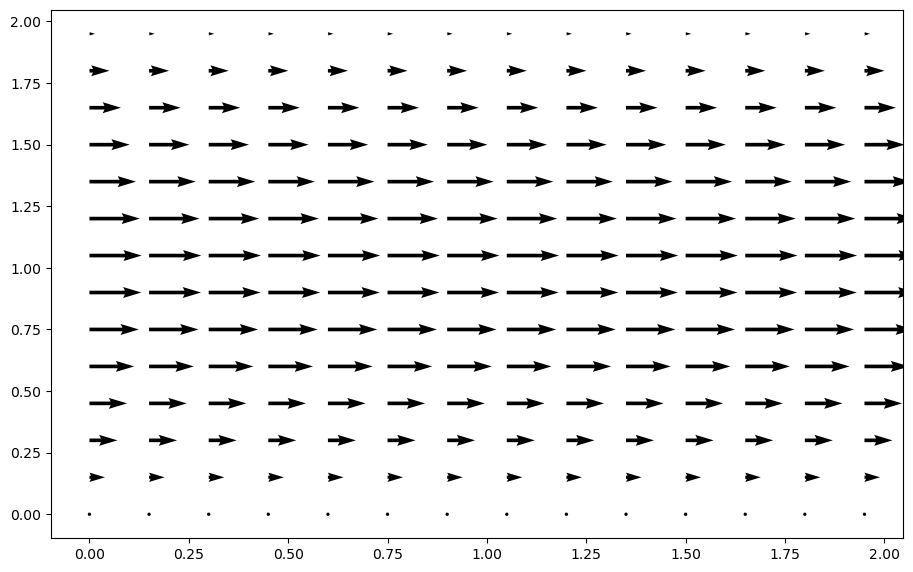

In [9]:
fig = pyplot.figure(figsize = (11,7), dpi=100)
pyplot.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]);